# Phase 5 — Results & Discussion + Report Artifacts (phase5.ipynb)

This notebook produces the **tables + plots** you need for the “Results and Discussion” section and for your final report/GitHub deliverables.


In [7]:
# Cell 1 — Imports
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F


In [12]:
# Cell 2 — Paths (robust project-root detection)

# If you run from: D:\INS\Assignment_2\notebooks
HERE = Path.cwd()
PROJECT_DIR = HERE.parent if HERE.name.lower() == "notebooks" else HERE

DATA_DIR    = PROJECT_DIR / "data"
RAW_DIR     = DATA_DIR / "raw"
PREP_DIR    = DATA_DIR / "processed"
OUT_DIR     = DATA_DIR / "out"

RESULTS_DIR = PROJECT_DIR / "results"
PHASE3_DIR  = RESULTS_DIR / "phase3"
RECON_DIR   = RESULTS_DIR / "reconstruction"   # where Phase 4 saves outputs

PHASE5_DIR  = RESULTS_DIR / "phase5"
FIG_DIR     = PHASE5_DIR / "figures"
TAB_DIR     = PHASE5_DIR / "tables"

for d in [PHASE5_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("PREP_DIR   :", PREP_DIR)
print("PHASE3_DIR :", PHASE3_DIR)
print("RECON_DIR  :", RECON_DIR)
print("PHASE5_DIR :", PHASE5_DIR)


PROJECT_DIR: d:\INS\Assignment_2
PREP_DIR   : d:\INS\Assignment_2\data\processed
PHASE3_DIR : d:\INS\Assignment_2\results\phase3
RECON_DIR  : d:\INS\Assignment_2\results\reconstruction
PHASE5_DIR : d:\INS\Assignment_2\results\phase5


In [13]:
# Cell 3 — Load processed events table (from Phase 2)

unified_path = PREP_DIR / "unified_events.parquet"
assert unified_path.exists(), f"Missing: {unified_path}. Re-run Phase 2 save step."

events = pd.read_parquet(unified_path).sort_values("timestamp").reset_index(drop=True)

print("events shape:", events.shape)
display(events.head(3))


events shape: (100000, 47)


,event_id,timestamp,event_type,source,severity,raw_log,user,action,object,process_id,...,meta_session_id,meta_risk_score,meta_confidence,log_source,host,ts_round,merge_key,attack_stage,label,time_delta_sec
0,8f7b1e90-e534-4a0b-b273-c58ce683dafe,2020-07-12 21:38:20+00:00,firewall,CrowdStrike v6.45.0,info,CEF:0|CrowdStrike v6.45.0|SIEM|1.0|100|firewal...,bsmith,deny,character,5037.0,...,4ff151bb-32a0-4cfc-9b8e-e38d70faba9b,62.23,0.60,FIREWALL,unknown,2020-07-12 21:38:20+00:00,2020-07-12 21:38:20+00:00|unknown|197.198.51.1...,benign,0,0.0
1,168ca1a1-e358-41d5-95e2-a0c747c6bc22,2020-07-14 14:15:20+00:00,network,Carbon Black v7.8.0,info,CEF:0|Carbon Black v7.8.0|SIEM|1.0|100|network...,bsmith,latency_spike,character,5037.0,...,23a671d9-444b-48e0-905d-701cac2a3dda,37.69,0.97,FIREWALL,unknown,2020-07-14 14:15:20+00:00,2020-07-14 14:15:20+00:00|unknown|33.122.86.82...,benign,0,0.0
2,77713c17-6a3d-40fc-a824-de4addaaf692,2020-07-15 12:06:45+00:00,cloud,Carbon Black v7.8.0,low,CEF:0|Carbon Black v7.8.0|SIEM|1.0|100|cloud|l...,smithheather,config_change,character,5037.0,...,529948a7-5777-4e4b-a6e5-6f83501519f8,34.61,0.80,SYSTEM,unknown,2020-07-15 12:06:45+00:00,2020-07-15 12:06:45+00:00|unknown|0.0.0.0|0.0.0.0,benign,0,0.0


In [ ]:
# Cell 4 — Load Phase 1 sequences + labels (npz)

SEQ_LEN = 100  # set to what you used in Phase 1/3

npz_path = PREP_DIR / f"sequences_len{SEQ_LEN}.npz"
assert npz_path.exists(), f"Missing: {npz_path}. Re-run Phase 1 final save cell."

npz = np.load(npz_path, allow_pickle=True)
X_train = npz["X_train"]; X_test = npz["X_test"]
m_train = npz["m_train"]; m_test = npz["m_test"]
y_train = npz["y_train"]; y_test = npz["y_test"]

print("X_test:", X_test.shape, "y_test:", y_test.shape)
print("y_test distribution:", pd.Series(y_test).value_counts().sort_index().to_dict())


X_test: (20000, 100, 112) y_test: (20000,)
y_test distribution: {0: 17849, 1: 494, 2: 462, 3: 266, 4: 493, 5: 436}


In [18]:
# Cell 5 — Load model predictions saved from Phase 3 (recommended)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import re

def find_first(base: Path, patterns):
    hits = []
    for p in patterns:
        hits += list(base.rglob(p))
    return sorted(hits)[0] if hits else None

# ---------- Try to load saved preds/probs ----------
pred1_path = find_first(PHASE3_DIR, [f"model1_pred_len{SEQ_LEN}.npy", "model1_pred*.npy"])
pred2_path = find_first(PHASE3_DIR, [f"model2_pred_len{SEQ_LEN}.npy", "model2_pred*.npy"])

probs1_path = find_first(PHASE3_DIR, [f"model1_probs_len{SEQ_LEN}.npy", "model1_probs*.npy"])
probs2_path = find_first(PHASE3_DIR, [f"model2_probs_len{SEQ_LEN}.npy", "model2_probs*.npy"])

y_pred1 = np.load(pred1_path) if pred1_path else None
y_pred2 = np.load(pred2_path) if pred2_path else None
probs1  = np.load(probs1_path) if probs1_path else None
probs2  = np.load(probs2_path) if probs2_path else None

print("pred1_path:", pred1_path)
print("pred2_path:", pred2_path)
print("probs1_path:", probs1_path)
print("probs2_path:", probs2_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ---------- Helper: run batched inference on X_test ----------
def batched_predict(model, X, M, batch_size=256):
    model.eval()
    preds = []
    probs = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32, device=device)
            mb = torch.tensor(M[i:i+batch_size], dtype=torch.float32, device=device)
            logits = model(xb, attn_mask_pad=mb)  # forward signature we used in Phase 4 model1 loader
            p = torch.softmax(logits, dim=1)
            preds.append(torch.argmax(p, dim=1).cpu().numpy())
            probs.append(p.cpu().numpy())
    return np.concatenate(preds), np.concatenate(probs)

# ---------- If Model 1 preds missing: load model1_best.pt and infer ----------
if y_pred1 is None:
    model1_path = find_first(PHASE3_DIR, ["model1_best.pt", "model1*.pt", "model1*.pth"])
    assert model1_path is not None, "Can't find Model 1 weights in results/phase3 (expected model1_best.pt)."
    print("Found Model 1 weights:", model1_path)

    # --- Minimal loader for YOUR model1 checkpoint (same idea as Phase 4 fixed loader) ---
    ckpt = torch.load(model1_path, map_location="cpu")
    if isinstance(ckpt, dict) and "state_dict" in ckpt: sd = ckpt["state_dict"]
    elif isinstance(ckpt, dict) and "model_state_dict" in ckpt: sd = ckpt["model_state_dict"]
    elif isinstance(ckpt, dict) and all(isinstance(v, torch.Tensor) for v in ckpt.values()): sd = ckpt
    else:
        sd = ckpt.state_dict() if hasattr(ckpt, "state_dict") else None
    assert sd is not None, "Unrecognized Model 1 checkpoint format."

    sd = {(k[7:] if k.startswith("module.") else k): v for k, v in sd.items()}

    in_dim = int(X_test.shape[-1])
    d_model = int(sd["proj.weight"].shape[0])
    pos_shape = tuple(sd["pos"].shape)
    num_classes = int(sd["head.1.weight"].shape[0])

    # layers count
    layer_idxs = []
    for k in sd.keys():
        m = re.match(r"layers\.(\d+)\.", k)
        if m: layer_idxs.append(int(m.group(1)))
    num_layers = max(layer_idxs) + 1

    # infer heads from tuning csv if exists, otherwise divisor
    def pick_nhead(d_model):
        csv_path = PHASE3_DIR / "model1_tuning_results.csv"
        if csv_path.exists():
            import pandas as pd
            df_t = pd.read_csv(csv_path)
            for cand in ["nhead", "num_heads", "heads"]:
                if cand in df_t.columns:
                    h = int(df_t.iloc[-1][cand])
                    if d_model % h == 0:
                        return h
        for h in [8,4,2,1]:
            if d_model % h == 0:
                return h
        return 1

    nhead = pick_nhead(d_model)

    # detect FFN paths from sd (same logic as Phase 4)
    def detect_ffn_paths(sd, d_model, layer_idx=0):
        prefix = f"layers.{layer_idx}."
        wkeys = [k for k in sd.keys()
                 if k.startswith(prefix) and k.endswith(".weight")
                 and ".self_attn." not in k and ".norm" not in k]
        mats = []
        for k in wkeys:
            W = sd[k]
            if W.dim() == 2:
                path = k[len(prefix):-len(".weight")]
                mats.append((path, tuple(W.shape)))
        # ff1: (dim_ff, d_model)
        ff1 = sorted([m for m in mats if m[1][1] == d_model and m[1][0] != d_model],
                     key=lambda x: x[1][0], reverse=True)[0]
        dim_ff = ff1[1][0]
        ff1_path = ff1[0]
        ff2_path = [m[0] for m in mats if m[1] == (d_model, dim_ff)][0]
        ff1_bias = f"{prefix}{ff1_path}.bias" in sd
        ff2_bias = f"{prefix}{ff2_path}.bias" in sd
        return ff1_path, ff2_path, int(dim_ff), ff1_bias, ff2_bias

    ff1_path, ff2_path, dim_ff, ff1_bias, ff2_bias = detect_ffn_paths(sd, d_model, 0)

    def set_by_path(root: nn.Module, path: str, module: nn.Module):
        parts = path.split(".")
        cur = root
        for i, part in enumerate(parts[:-1]):
            nxt = parts[i+1]
            if not hasattr(cur, part):
                setattr(cur, part, nn.ModuleDict() if nxt.isdigit() else nn.Module())
            cur = getattr(cur, part)
            if isinstance(cur, nn.ModuleDict) and (nxt not in cur) and i < len(parts) - 2:
                cur[nxt] = nn.ModuleDict() if parts[i+2].isdigit() else nn.Module()
                cur = cur[nxt]
        last = parts[-1]
        if isinstance(cur, nn.ModuleDict):
            cur[last] = module
        else:
            setattr(cur, last, module)

    def get_by_path(root: nn.Module, path: str) -> nn.Module:
        cur = root
        for part in path.split("."):
            cur = cur[part] if isinstance(cur, nn.ModuleDict) else getattr(cur, part)
        return cur

    class EncoderLayer(nn.Module):
        def __init__(self, d_model, nhead, dim_ff, ff1_path, ff2_path, ff1_bias, ff2_bias, dropout=0.1):
            super().__init__()
            self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)
            self.dropout1 = nn.Dropout(dropout)
            self.dropout2 = nn.Dropout(dropout)
            self.dropout = nn.Dropout(dropout)
            self.act = nn.ReLU()
            set_by_path(self, ff1_path, nn.Linear(d_model, dim_ff, bias=ff1_bias))
            set_by_path(self, ff2_path, nn.Linear(dim_ff, d_model, bias=ff2_bias))
            self._ff1_path = ff1_path
            self._ff2_path = ff2_path

        def forward(self, x, key_padding_mask=None):
            attn_out, _ = self.self_attn(x, x, x, key_padding_mask=key_padding_mask, need_weights=False)
            x = self.norm1(x + self.dropout1(attn_out))
            ff1 = get_by_path(self, self._ff1_path)
            ff2 = get_by_path(self, self._ff2_path)
            ff = ff2(self.dropout(self.act(ff1(x))))
            x = self.norm2(x + self.dropout2(ff))
            return x

    class Model1(nn.Module):
        def __init__(self, in_dim, d_model, nhead, num_layers, dim_ff, pos_shape, num_classes,
                     ff1_path, ff2_path, ff1_bias, ff2_bias, dropout=0.1):
            super().__init__()
            self.proj = nn.Linear(in_dim, d_model)
            self.cls = nn.Parameter(torch.zeros(1,1,d_model))
            self.register_buffer("pos", torch.zeros(pos_shape), persistent=True)
            self.layers = nn.ModuleList([
                EncoderLayer(d_model, nhead, dim_ff, ff1_path, ff2_path, ff1_bias, ff2_bias, dropout=dropout)
                for _ in range(num_layers)
            ])
            self.head = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, num_classes),
            )

        def forward(self, x, attn_mask_pad=None):
            x = self.proj(x)
            B, L, D = x.shape
            x = torch.cat([self.cls.expand(B,1,D), x], dim=1)  # CLS
            if self.pos.dim() == 3:
                x = x + self.pos[:, :L+1, :]
            else:
                x = x + self.pos[:L+1].unsqueeze(0)

            if attn_mask_pad is not None:
                cls_mask = torch.ones((B,1), dtype=attn_mask_pad.dtype, device=attn_mask_pad.device)
                m = torch.cat([cls_mask, attn_mask_pad], dim=1)
                key_padding_mask = (m == 0)
            else:
                key_padding_mask = None

            for layer in self.layers:
                x = layer(x, key_padding_mask=key_padding_mask)

            pooled = x[:,0,:]
            return self.head(pooled)

    model1 = Model1(in_dim, d_model, nhead, num_layers, dim_ff, pos_shape, num_classes,
                    ff1_path, ff2_path, ff1_bias, ff2_bias).to(device)
    model1.load_state_dict(sd, strict=True)
    model1.eval()

    y_pred1, probs1 = batched_predict(model1, X_test, m_test, batch_size=256)

    # Save for reuse
    np.save(PHASE3_DIR / f"model1_pred_len{SEQ_LEN}.npy", y_pred1)
    np.save(PHASE3_DIR / f"model1_probs_len{SEQ_LEN}.npy", probs1)
    print("Saved Model1 preds/probs to:", PHASE3_DIR)

# ---------- Model 2: if preds missing, we compute from model2_classifier.pt if possible ----------
# NOTE: We can only auto-recompute Model2 if you trained it as a classifier with a saved classifier checkpoint.
if y_pred2 is None:
    model2_path = find_first(PHASE3_DIR, ["model2_classifier.pt", "model2*.pt", "model2*.pth"])
    if model2_path is None:
        print("Model2 weights not found -> skipping Model2 in Phase 5.")
    else:
        print("Found Model2 weights:", model2_path)
        # If your Model2 is a different architecture, it's safest to load preds from Phase 3.
        # For now we simply warn rather than guessing the whole Model2 architecture.
        print("⚠️ Please load/save Model2 predictions from Phase 3 to compare both models cleanly.")

print("Done. Now you have at least Model1 preds available.")


pred1_path: d:\INS\Assignment_2\results\phase3\model1_pred_len100.npy
pred2_path: d:\INS\Assignment_2\results\phase3\model2_pred_len100.npy
probs1_path: d:\INS\Assignment_2\results\phase3\model1_probs_len100.npy
probs2_path: d:\INS\Assignment_2\results\phase3\model2_probs_len100.npy
device: cuda
Done. Now you have at least Model1 preds available.


In [32]:
# Cell 6 — Results tables (Model 1 vs Model 2)

LABEL_NAMES = {
    0: "benign",
    1: "recon",
    2: "exploit",
    3: "privilege_escalation",
    4: "lateral_movement",
    5: "exfiltration",
}

def build_metrics_df(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=sorted(LABEL_NAMES.keys()), zero_division=0
    )
    df = pd.DataFrame({
        "label_id": sorted(LABEL_NAMES.keys()),
        "label_name": [LABEL_NAMES[i] for i in sorted(LABEL_NAMES.keys())],
        "precision": pr,
        "recall": rc,
        "f1": f1,
        "support": sup
    })
    summary = {
        "accuracy": float(acc),
        "macro_precision": float(df["precision"].mean()),
        "macro_recall": float(df["recall"].mean()),
        "macro_f1": float(df["f1"].mean())
    }
    return df, summary

def save_metrics(name, y_true, y_pred):
    df, summary = build_metrics_df(y_true, y_pred)
    df.to_csv(TAB_DIR / f"{name}_per_class.csv", index=False)
    with open(TAB_DIR / f"{name}_summary.json", "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)
    print(name, summary)
    display(df)
    return df, summary

m1_df = m1_sum = None
m2_df = m2_sum = None

if y_pred1 is not None:
    m1_df, m1_sum = save_metrics("model1", y_test, y_pred1)
if y_pred2 is not None:
    m2_df, m2_sum = save_metrics("model2", y_test, y_pred2)


model1 {'accuracy': 0.9448, 'macro_precision': 0.6569584410559454, 'macro_recall': 0.6097357264889339, 'macro_f1': 0.627836173560262}


,label_id,label_name,precision,recall,f1,support
0,0,benign,0.941751,1.000000,0.970002,17849
1,1,recon,0.000000,0.000000,0.000000,494
2,2,exploit,0.000000,0.000000,0.000000,462
3,3,privilege_escalation,1.000000,0.992481,0.996226,266
4,4,lateral_movement,1.000000,0.993915,0.996948,493
5,5,exfiltration,1.000000,0.672018,0.803841,436


model2 {'accuracy': 0.84525, 'macro_precision': 0.1582496995868485, 'macro_recall': 0.1664589955367633, 'macro_f1': 0.16216800513939517}


,label_id,label_name,precision,recall,f1,support
0,0,benign,0.891676,0.945879,0.917978,17849
1,1,recon,0.000000,0.000000,0.000000,494
2,2,exploit,0.000000,0.000000,0.000000,462
3,3,privilege_escalation,0.014493,0.015038,0.014760,266
4,4,lateral_movement,0.027897,0.026369,0.027112,493
5,5,exfiltration,0.015432,0.011468,0.013158,436


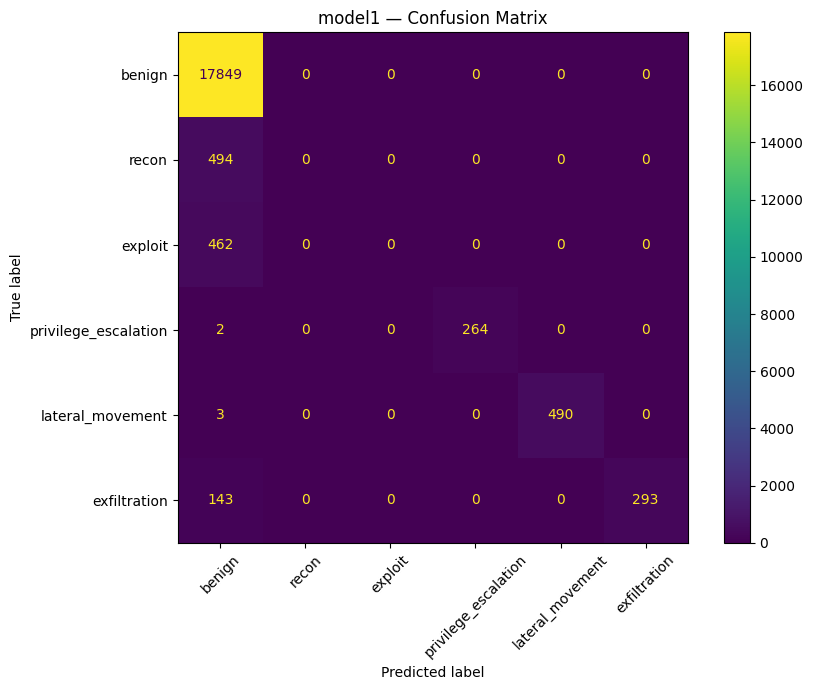

Saved: d:\INS\Assignment_2\results\phase5\figures\model1_confusion_matrix.png


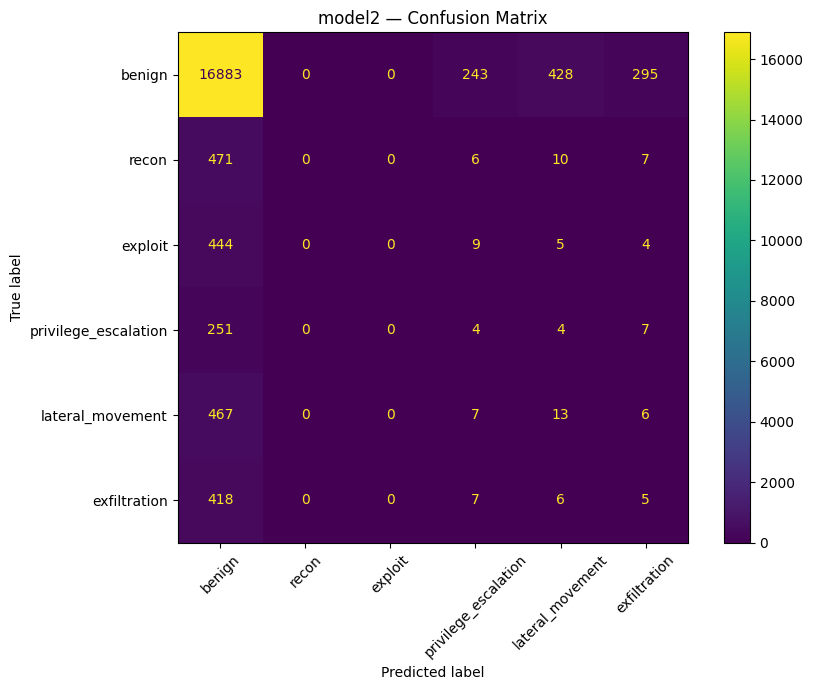

Saved: d:\INS\Assignment_2\results\phase5\figures\model2_confusion_matrix.png


In [33]:
# Cell 7 — Confusion matrices (save PNGs)

def plot_cm(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=sorted(LABEL_NAMES.keys()))
    disp = ConfusionMatrixDisplay(cm, display_labels=[LABEL_NAMES[i] for i in sorted(LABEL_NAMES.keys())])
    fig, ax = plt.subplots(figsize=(9, 7))
    disp.plot(ax=ax, xticks_rotation=45, values_format="d")
    plt.title(f"{name} — Confusion Matrix")
    plt.tight_layout()
    out = FIG_DIR / f"{name}_confusion_matrix.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

if y_pred1 is not None:
    plot_cm("model1", y_test, y_pred1)

if y_pred2 is not None:
    plot_cm("model2", y_test, y_pred2)


probs1_path: d:\INS\Assignment_2\results\phase3\model1_probs_len100.npy
probs2_path: d:\INS\Assignment_2\results\phase3\model2_probs_len100.npy
Model1 probs shape: (20000, 6)


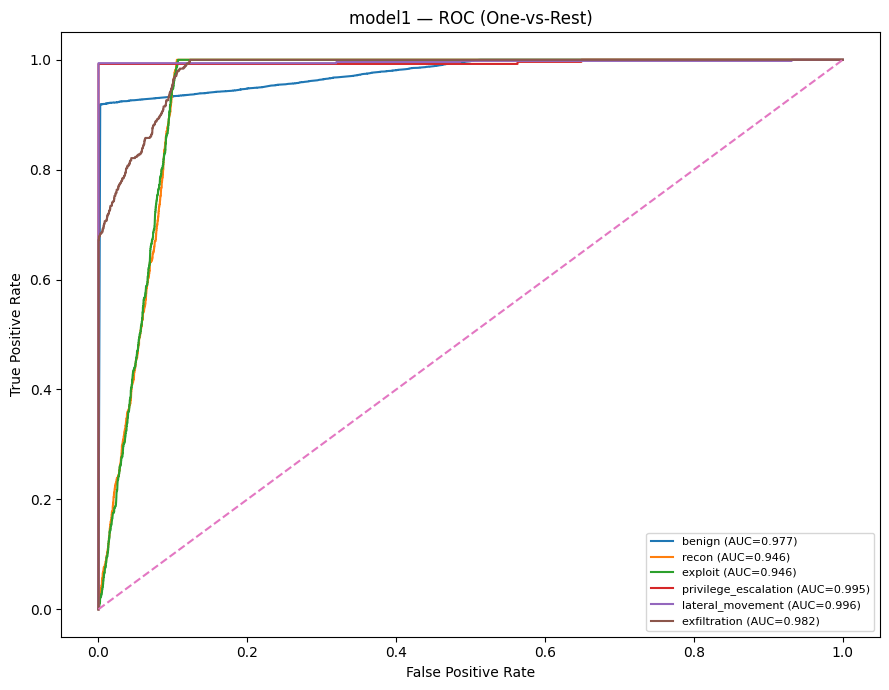

Saved: d:\INS\Assignment_2\results\phase5\figures\model1_roc_ovr.png
Model2 probs shape: (20000, 6)


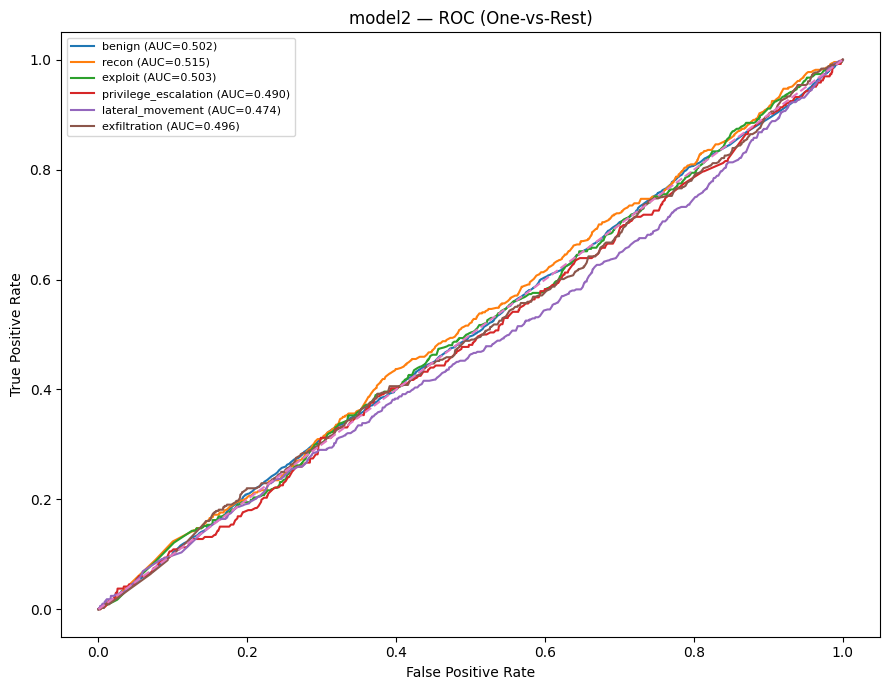

Saved: d:\INS\Assignment_2\results\phase5\figures\model2_roc_ovr.png


In [34]:
# Cell 8 — ROC/AUC (One-vs-Rest) if you have probability scores
# NOTE: ROC needs per-class scores. If you didn't save logits/probs in Phase 3, skip this cell.

# Expected saved files (optional):
#  - model1_probs_len{SEQ_LEN}.npy  shape: (N, C)
#  - model2_probs_len{SEQ_LEN}.npy  shape: (N, C)

probs1_path = find_first(PHASE3_DIR, [f"model1_probs_len{SEQ_LEN}.npy", "model1_probs*.npy"])
probs2_path = find_first(PHASE3_DIR, [f"model2_probs_len{SEQ_LEN}.npy", "model2_probs*.npy"])

probs1 = np.load(probs1_path) if probs1_path is not None else None
probs2 = np.load(probs2_path) if probs2_path is not None else None

print("probs1_path:", probs1_path)
print("probs2_path:", probs2_path)

def plot_roc_ovr(name, y_true, probs):
    classes = sorted(LABEL_NAMES.keys())
    y_bin = label_binarize(y_true, classes=classes)

    fig, ax = plt.subplots(figsize=(9, 7))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{LABEL_NAMES[cls]} (AUC={roc_auc:.3f})")

    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{name} — ROC (One-vs-Rest)")
    ax.legend(fontsize=8)
    plt.tight_layout()

    out = FIG_DIR / f"{name}_roc_ovr.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

if probs1 is not None:
    print("Model1 probs shape:", probs1.shape)
    plot_roc_ovr("model1", y_test, probs1)
else:
    print("No model1 probs saved → skip ROC for model1.")

if probs2 is not None:
    print("Model2 probs shape:", probs2.shape)
    plot_roc_ovr("model2", y_test, probs2)
else:
    print("No model2 probs saved → skip ROC for model2.")


Model1 macro ROC-AUC: 0.9736921978130776


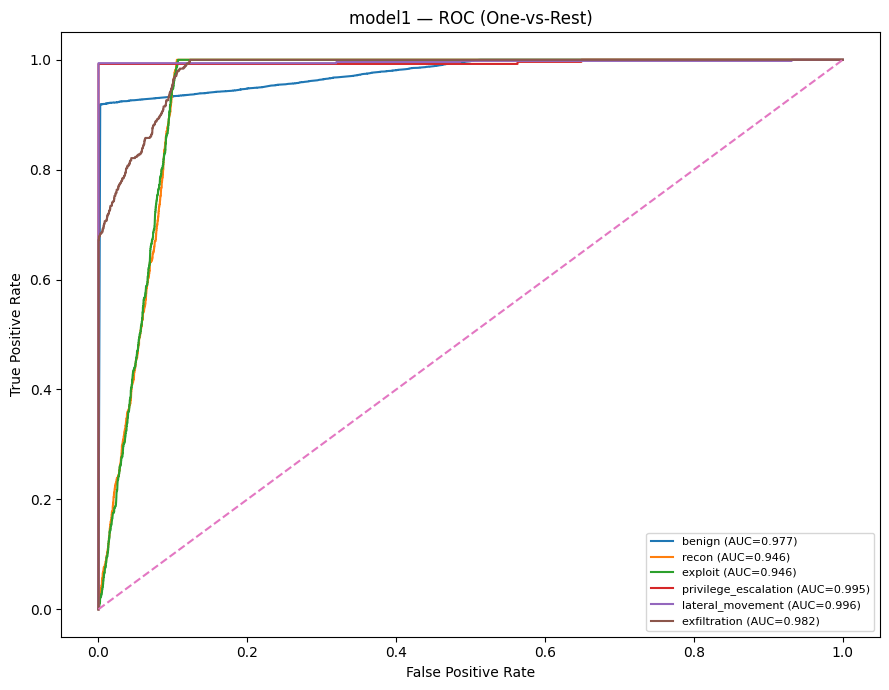

Saved: d:\INS\Assignment_2\results\phase5\figures\model1_roc_ovr.png
Model2 macro ROC-AUC: 0.4966499468554284


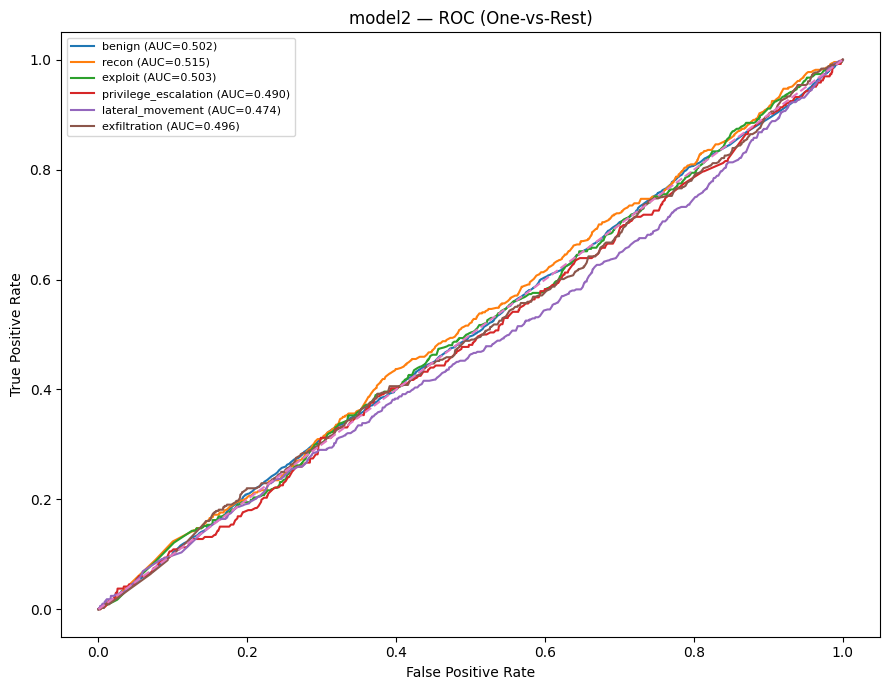

Saved: d:\INS\Assignment_2\results\phase5\figures\model2_roc_ovr.png


In [35]:
# Cell 9 — Load reconstruction outputs from Phase 4 + show 1 chain example

def plot_roc_ovr(name, y_true, probs):
    classes = sorted(LABEL_NAMES.keys())
    y_bin = label_binarize(y_true, classes=classes)

    fig, ax = plt.subplots(figsize=(9, 7))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{LABEL_NAMES[cls]} (AUC={roc_auc:.3f})")

    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{name} — ROC (One-vs-Rest)")
    ax.legend(fontsize=8)
    plt.tight_layout()

    out = FIG_DIR / f"{name}_roc_ovr.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

# Optional macro ROC-AUC
def macro_roc_auc(y_true, probs):
    return roc_auc_score(y_true, probs, multi_class="ovr", average="macro")

if probs1 is not None:
    print("Model1 macro ROC-AUC:", macro_roc_auc(y_test, probs1))
    plot_roc_ovr("model1", y_test, probs1)
else:
    print("No model1 probs saved → skip ROC for model1.")

if probs2 is not None:
    print("Model2 macro ROC-AUC:", macro_roc_auc(y_test, probs2))
    plot_roc_ovr("model2", y_test, probs2)
else:
    print("No model2 probs saved → skip ROC for model2.")


In [36]:
# Cell 10 — Load Phase 4 reconstructed chains + show one example chain

chains_path = RECON_DIR / "reconstructed_chains.json"
assert chains_path.exists(), f"Missing: {chains_path}. Make sure Phase 4 saved it into results/reconstruction/"

chains = json.load(open(chains_path, "r", encoding="utf-8"))
print("Loaded reconstructed chains:", len(chains))

# One chain example (required in report discussion)
chain = chains[0]
print("Example chain_id:", chain.get("chain_id"))
print("Method:", chain.get("method"))
print("Score:", chain.get("score"))
print("Start:", chain.get("start_time"), "| End:", chain.get("end_time"))

chain_ids = set(chain["events"])
ex = events[events["event_id"].isin(chain_ids)].copy().sort_values("timestamp")

cols = [c for c in ["event_id","timestamp","host","src_ip","dst_ip","user","event_type","attack_stage","label"] if c in ex.columns]
display(ex[cols])


Loaded reconstructed chains: 1
Example chain_id: 2
Method: correlation_graph
Score: 2.4554388406571555
Start: 2025-03-11 02:30:03+00:00 | End: 2025-03-11 04:04:38+00:00


,event_id,timestamp,host,src_ip,dst_ip,user,event_type,attack_stage,label
32983,bdbfe8ea-5e22-46fe-b137-9bf7fbc5889e,2025-03-11 02:30:03+00:00,unknown,61.133.85.187,116.222.129.193,bsmith,firewall,benign,0
32985,b033f6e5-d2d3-4180-b99f-25215886dfaa,2025-03-11 02:40:44+00:00,unknown,34.156.143.39,0.0.0.0,bsmith,ids_alert,recon,1
32992,11e52f2a-17f9-455e-bf81-05dd6e5b6b93,2025-03-11 02:51:39+00:00,unknown,170.124.104.81,0.0.0.0,bsmith,ids_alert,exploit,2
32993,0995efa5-02f7-44d7-8364-38134032fb41,2025-03-11 02:56:16+00:00,unknown,71.251.131.254,150.188.144.63,bsmith,ids_alert,recon,1
32997,341a9b02-5179-4a45-90f1-3008c183691e,2025-03-11 03:08:44+00:00,unknown,10.90.156.55,55.204.102.3,bsmith,ids_alert,benign,0
33005,27f4a667-c694-47fc-bf4f-a55a91e78a7a,2025-03-11 03:27:11+00:00,unknown,119.174.169.130,104.83.158.77,bsmith,firewall,lateral_movement,4
33012,4642f57f-f11c-4673-a19b-fd9719e886bb,2025-03-11 03:43:58+00:00,unknown,0.0.0.0,0.0.0.0,jordan59,cloud,privilege_escalation,3
33014,a383b392-38b3-4094-91c4-e8c149f2b15d,2025-03-11 03:44:31+00:00,unknown,87.95.166.255,0.0.0.0,bsmith,ids_alert,benign,0
33023,4fa10f3a-e089-4464-8d46-dd102d4f88a3,2025-03-11 04:04:38+00:00,unknown,155.95.47.8,0.0.0.0,nancygray,auth,benign,0


In [37]:
# Cell 11 — Reconstruction summary stats (helps you write “how well”)

def stage_progression_score(labels):
    # 0 benign, 1 recon, 2 exploit, 3 priv-esc, 4 lateral, 5 exfil
    if len(labels) < 2:
        return 1.0
    ok = 0
    for a, b in zip(labels[:-1], labels[1:]):
        if b >= a:
            ok += 1
    return ok / (len(labels) - 1)

for ch in chains[:5]:
    ev = events[events["event_id"].isin(ch["events"])].copy().sort_values("timestamp")
    if "label" in ev.columns:
        lbl = ev["label"].astype(int).tolist()
        non_benign_ratio = float(np.mean(np.array(lbl) != 0))
        prog = stage_progression_score(lbl)
        print(
            f"chain_id={ch.get('chain_id')}  method={ch.get('method')}  score={ch.get('score')}"
            f"  non_benign_ratio={non_benign_ratio:.3f}  progression={prog:.3f}"
        )


chain_id=2  method=correlation_graph  score=2.4554388406571555  non_benign_ratio=0.556  progression=0.500


## Discussion prompts (fill in the report)

Use these outputs to answer the required Results & Discussion questions:

- Which Transformer performed better and why?
- Which attack stages were easier/harder to detect?
- How well did the model reconstruct the attack sequence?
- What was the impact of sequence length / embeddings / event representation?


In [38]:
# Cell 12 — Auto “Discussion bullets” (copy into your IEEE report)

def fmt_summary(name, summ):
    if summ is None: 
        return None
    return f"{name}: accuracy={summ['accuracy']:.4f}, macro-F1={summ['macro_f1']:.4f} (macro-recall={summ['macro_recall']:.4f})."

print("=== Copy into report (Results & Discussion) ===")
if m1_sum: print("-", fmt_summary("Model 1", m1_sum))
if m2_sum: print("-", fmt_summary("Model 2", m2_sum))

# easiest/hardest (by recall)
def easiest_hardest(df, tag):
    if df is None: return
    best = df.sort_values("recall", ascending=False).iloc[0]
    worst = df.sort_values("recall", ascending=True).iloc[0]
    print(f"- {tag} easiest stage: {best['label_name']} (recall={best['recall']:.3f})")
    print(f"- {tag} hardest stage: {worst['label_name']} (recall={worst['recall']:.3f})")

easiest_hardest(m1_df, "Model 1")
easiest_hardest(m2_df, "Model 2")

# reconstruction note
if len(chains) > 0:
    c0 = chains[0]
    print(f"- Reconstruction: generated {len(chains)} chain(s). Example chain_1 uses method={c0.get('method')} with score={c0.get('score')}.")


=== Copy into report (Results & Discussion) ===
- Model 1: accuracy=0.9448, macro-F1=0.6278 (macro-recall=0.6097).
- Model 2: accuracy=0.8452, macro-F1=0.1622 (macro-recall=0.1665).
- Model 1 easiest stage: benign (recall=1.000)
- Model 1 hardest stage: recon (recall=0.000)
- Model 2 easiest stage: benign (recall=0.946)
- Model 2 hardest stage: recon (recall=0.000)
- Reconstruction: generated 1 chain(s). Example chain_1 uses method=correlation_graph with score=2.4554388406571555.


In [40]:
# Final deliverables check (Phase 4 + Phase 5)

required_phase4 = [
    RECON_DIR / "reconstructed_chains.json",
    RECON_DIR / "chain_1_timeline.png",
    RECON_DIR / "chain_1_graph.png",
]

required_phase5 = [
    TAB_DIR / "model1_per_class.csv",
    TAB_DIR / "model1_summary.json",
    FIG_DIR / "model1_confusion_matrix.png",
    TAB_DIR / "model2_per_class.csv",
    TAB_DIR / "model2_summary.json",
    FIG_DIR / "model2_confusion_matrix.png",
    # ROC is required by spec, but only possible if you saved probs:
    FIG_DIR / "model1_roc_ovr.png",
    FIG_DIR / "model2_roc_ovr.png",
]

def check_files(paths, title):
    missing = [p for p in paths if not p.exists()]
    print(f"\n{title}")
    print("OK:", len(paths) - len(missing), "/", len(paths))
    if missing:
        print("Missing:")
        for p in missing:
            print(" -", p)
    else:
        print("All present.")

check_files(required_phase4, "Phase 4 required outputs")
check_files(required_phase5, "Phase 5 outputs (ROC depends on saved probs)")



Phase 4 required outputs
OK: 3 / 3
All present.

Phase 5 outputs (ROC depends on saved probs)
OK: 8 / 8
All present.
